In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras import (
    backend as K,
    losses,
    optimizers,
    layers,
    models,
    utils,
    callbacks
)
from tensorflow.keras import layers, models, optimizers, callbacks

In [2]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df
#train
train = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\train')
#test
test = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\test')
#valid
valid = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\valid')

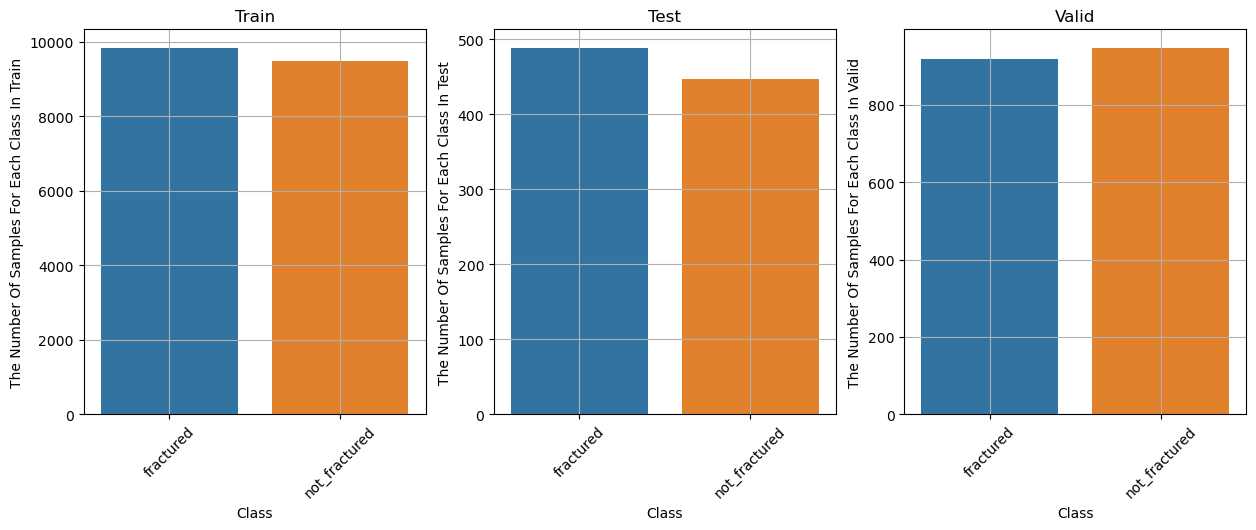

In [3]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,2)
ax = sns.countplot(x=test.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,3)
ax = sns.countplot(x=valid.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Valid")
plt.title('Valid')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

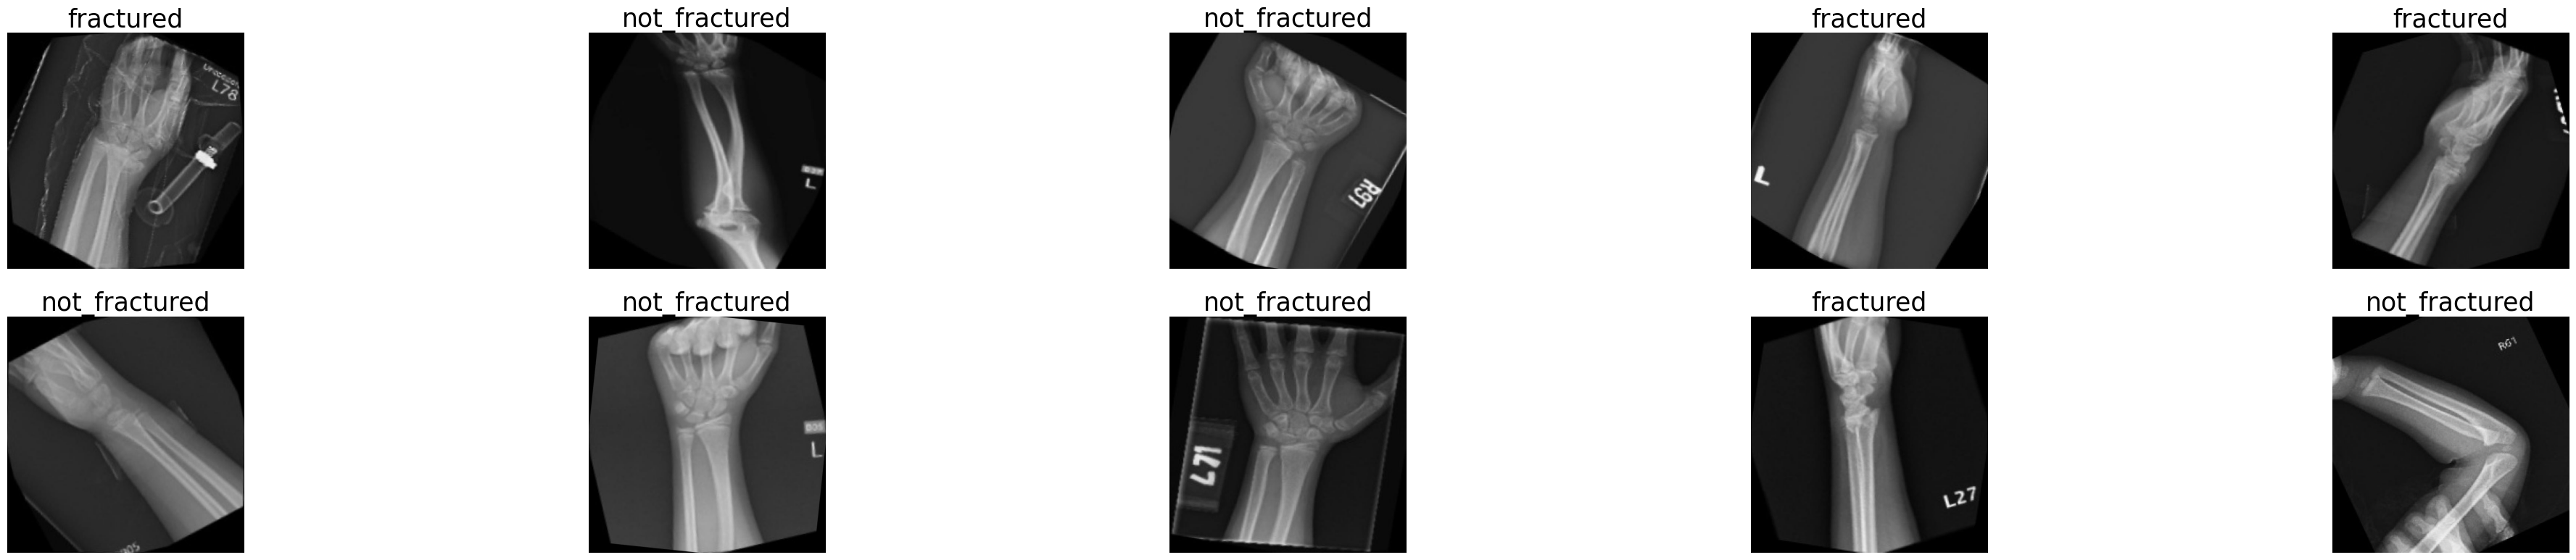

In [6]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),10)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

In [ ]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
valid_generator = datagen.flow_from_dataframe(
    valid,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

In [8]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))  
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu)) 
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2))) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2))) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Dense(128,activation=tf.nn.relu)) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

In [14]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model.fit_generator(train_generator,epochs=10,validation_data=valid_generator,callbacks=[checkpoint_cb,early_stopping_cb]) 

C:\Users\HP\AppData\Local\Temp\ipykernel_6152\1253609035.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_generator,epochs=10,validation_data=valid_generator,callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/10


605/605 [==============================] - ETA: 0s - loss: 1.5355 - accuracy: 0.6496 - specificity_at_sensitivity: 0.7248 - auc: 0.6962

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


605/605 [==============================] - 1625s 3s/step - loss: 1.5355 - accuracy: 0.6496 - specificity_at_sensitivity: 0.7248 - auc: 0.6962 - val_loss: 1.0121 - val_accuracy: 0.6718 - val_specificity_at_sensitivity: 0.8022 - val_auc: 0.7464
Epoch 2/10
605/605 [==============================] - 1690s 3s/step - loss: 0.5730 - accuracy: 0.6995 - specificity_at_sensitivity: 0.7520 - auc: 0.7687 - val_loss: 0.6593 - val_accuracy: 0.6751 - val_specificity_at_sensitivity: 0.5130 - val_auc: 0.7385
Epoch 3/10
605/605 [==============================] - 1614s 3s/step - loss: 0.4555 - accuracy: 0.7577 - specificity_at_sensitivity: 0.8798 - auc: 0.8444 - val_loss: 0.3545 - val_accuracy: 0.8201 - val_specificity_at_sensitivity: 0.9761 - val_auc: 0.9107
Epoch 4/10
605/605 [==============================] - 1699s 3s/step - loss: 0.3887 - accuracy: 0.8002 - specificity_at_sensitivity: 0.9731 - auc: 0.8978 - val_loss: 0.2148 - val_accuracy: 0.8913 - val_specificity_at_sensitivity: 0.9989 - val_auc: 0.

In [15]:
hist_=pd.DataFrame(hist.history)
hist_ 

,loss,accuracy,specificity_at_sensitivity,auc,val_loss,val_accuracy,val_specificity_at_sensitivity,val_auc
0,1.535505,0.649594,0.724789,0.696207,1.012147,0.671842,0.802174,0.746440
1,0.573048,0.699467,0.752006,0.768739,0.659313,0.675054,0.513043,0.738477
2,0.455487,0.757722,0.879760,0.844376,0.354502,0.820129,0.976087,0.910686
3,0.388731,0.800248,0.973088,0.897755,0.214782,0.891328,0.998913,0.965621
4,0.284653,0.855036,0.995836,0.943121,0.264513,0.887045,1.000000,0.963260
5,0.236337,0.879145,0.997664,0.959595,0.241511,0.875803,1.000000,0.969109
6,0.197804,0.899012,0.998172,0.972258,0.108198,0.946467,0.997826,0.992036
7,0.167827,0.919499,0.998883,0.980594,0.063124,0.973233,1.000000,0.997959
8,0.136687,0.935951,0.998680,0.986873,0.067428,0.967345,1.000000,0.997318
9,0.118593,0.947074,0.998781,0.990658,0.201395,0.925589,0.989130,0.978781


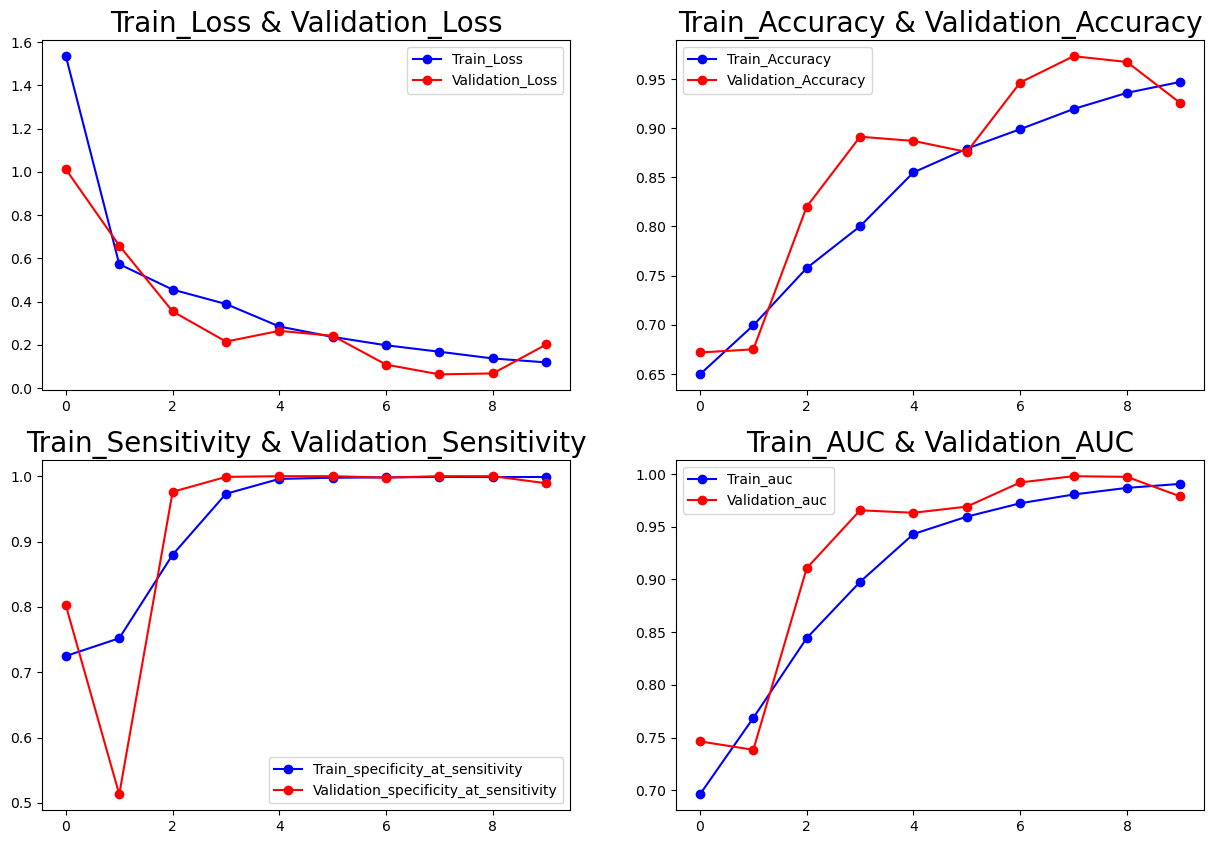

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [17]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

30/30 [==============================] - 21s 703ms/step - loss: 0.1783 - accuracy: 0.9306 - specificity_at_sensitivity: 0.9959 - auc: 0.9845
Test Loss = 0.17829455435276031
Test Accuracy = 0.9305555820465088
Test Sensitivity = 0.9959100484848022
Test AUC = 0.9844566583633423


In [18]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

30/30 [==============================] - 13s 400ms/step


,Actual,Prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
931,1,1
932,1,1
933,1,1
934,1,1


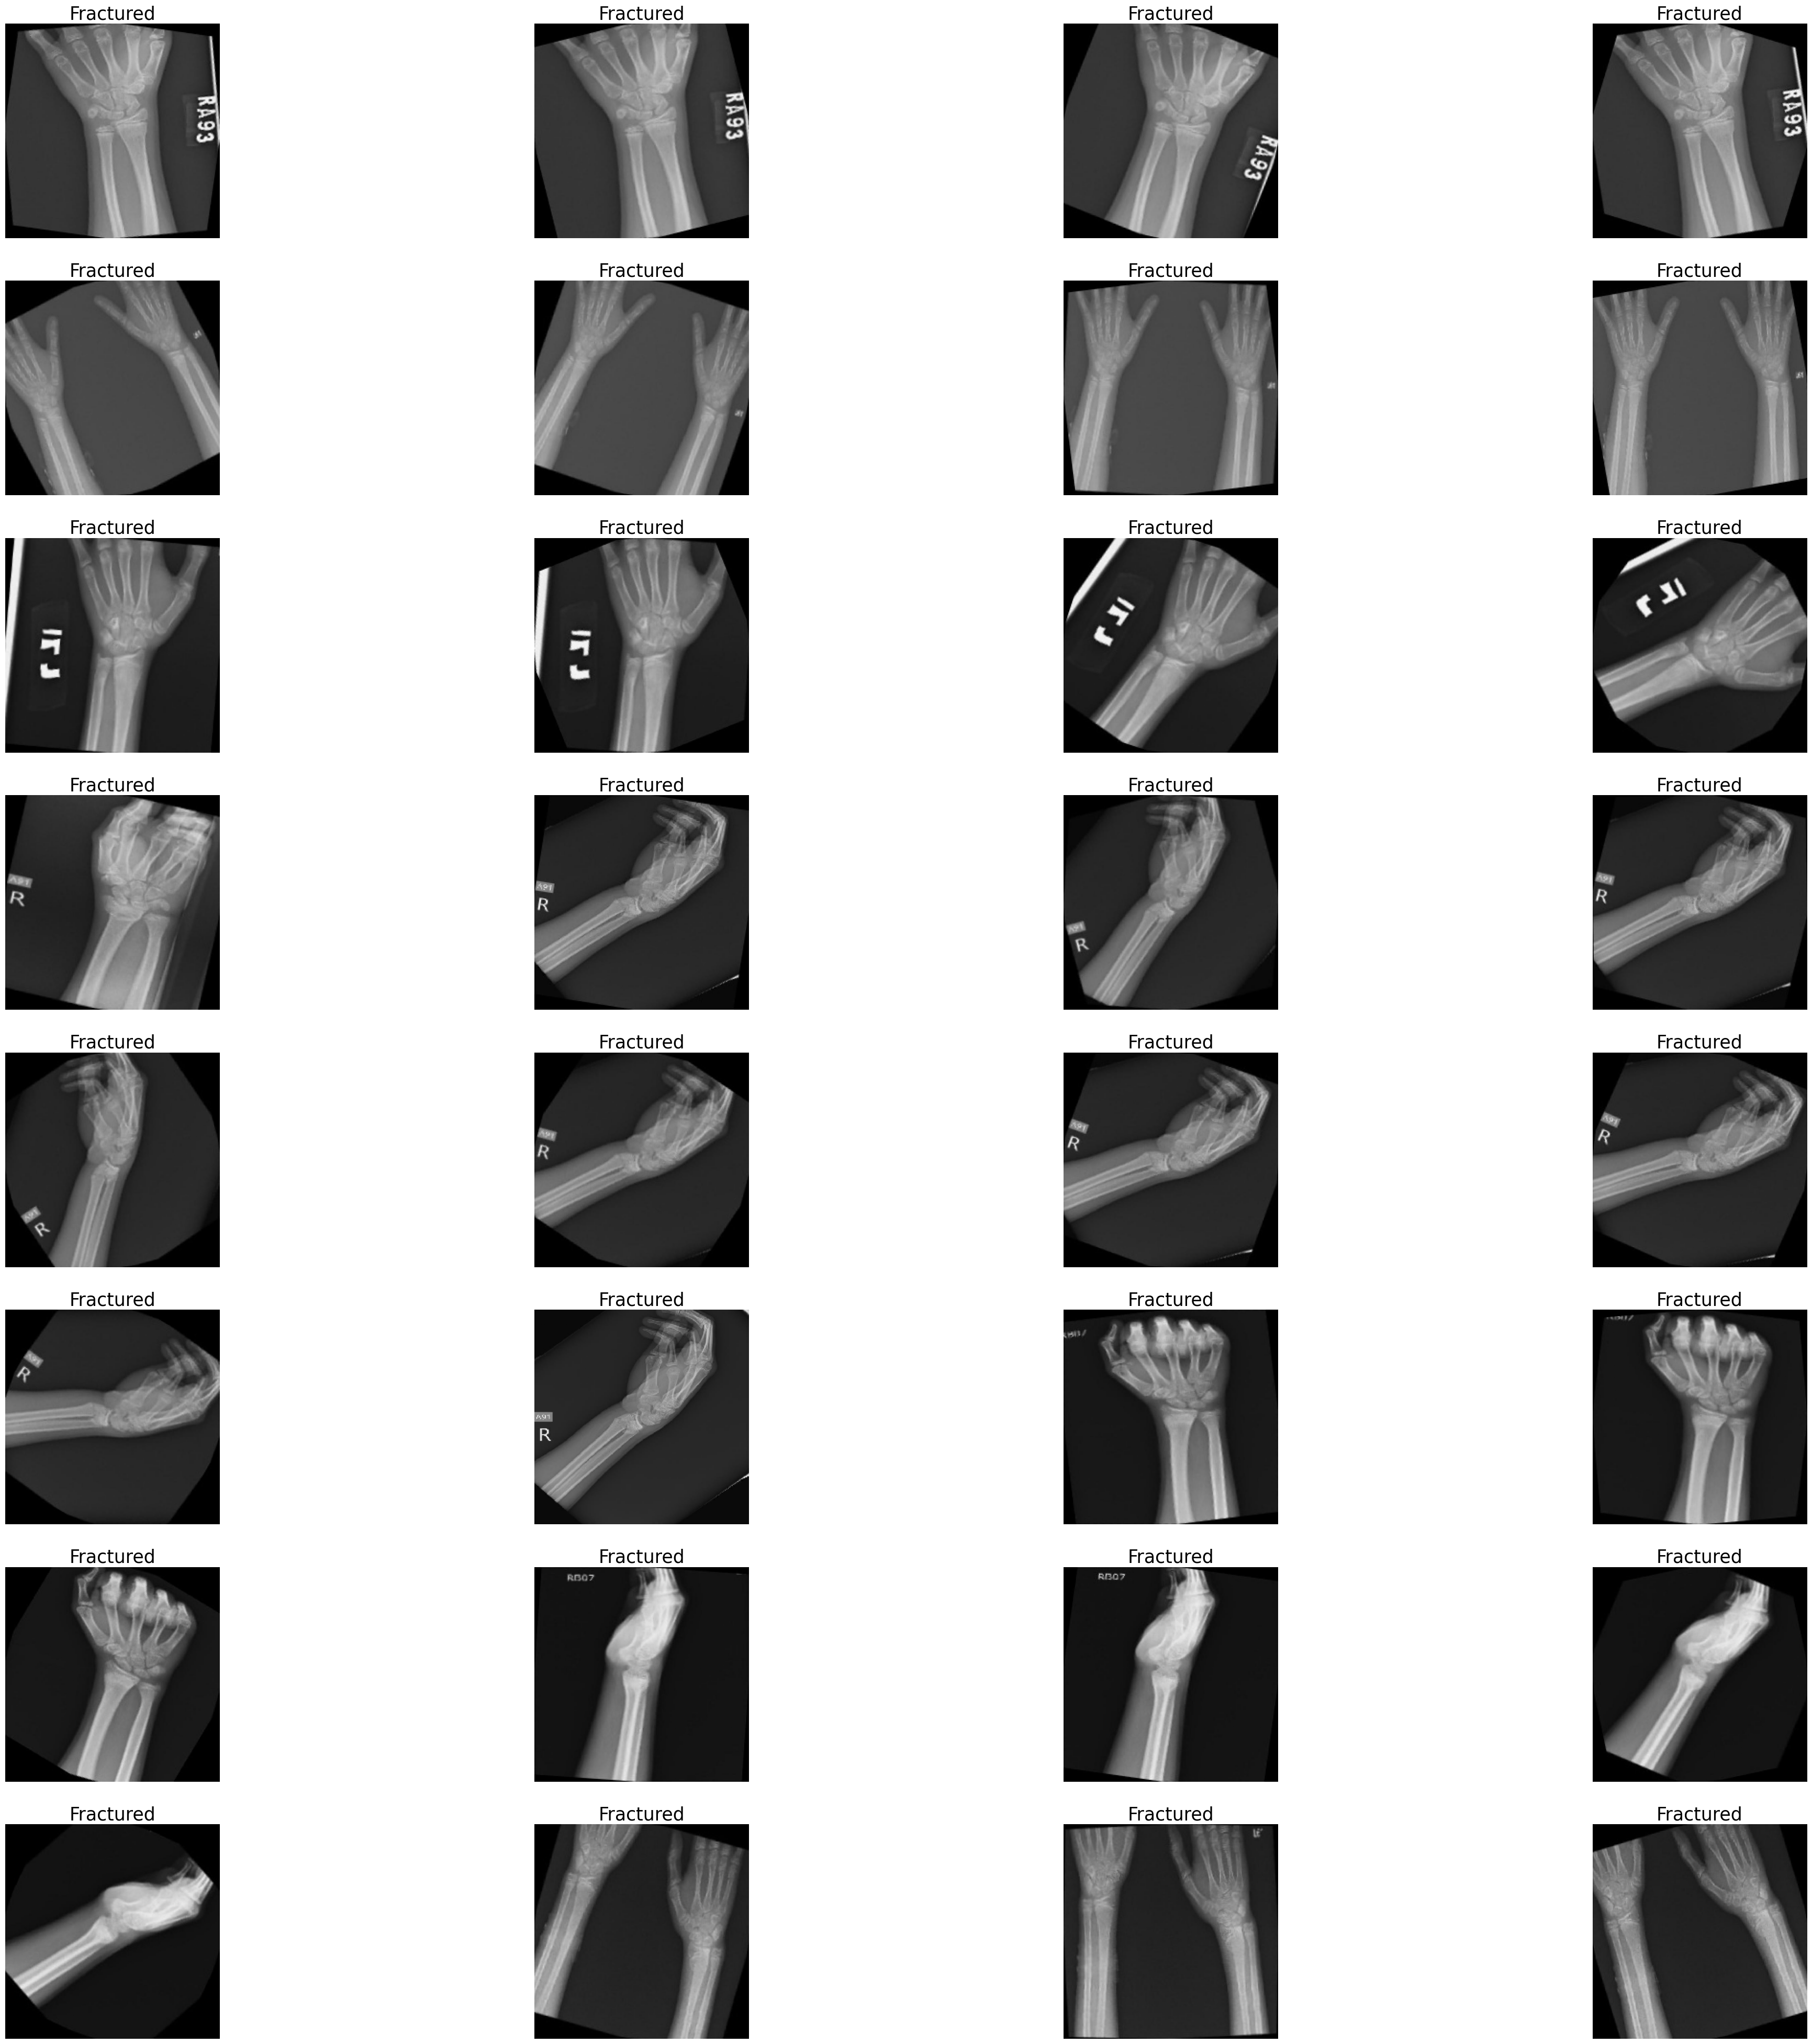

In [19]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

array([[435,  54],
       [ 11, 436]], dtype=int64)

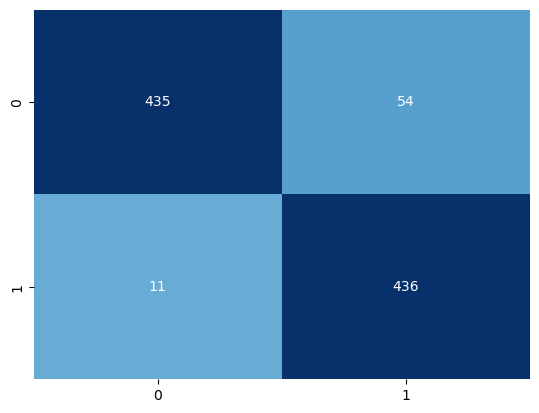

In [20]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [21]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.98      0.89      0.93       489
           1       0.89      0.98      0.93       447

    accuracy                           0.93       936
   macro avg       0.93      0.93      0.93       936
weighted avg       0.93      0.93      0.93       936



In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [24]:
# For multi-class ROC 
y_test_binarized = label_binarize(y_test, classes=[0, 1]) 
y_pred_prob = predictions.ravel()  
fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_prob)
roc_auc = auc(fpr, tpr)

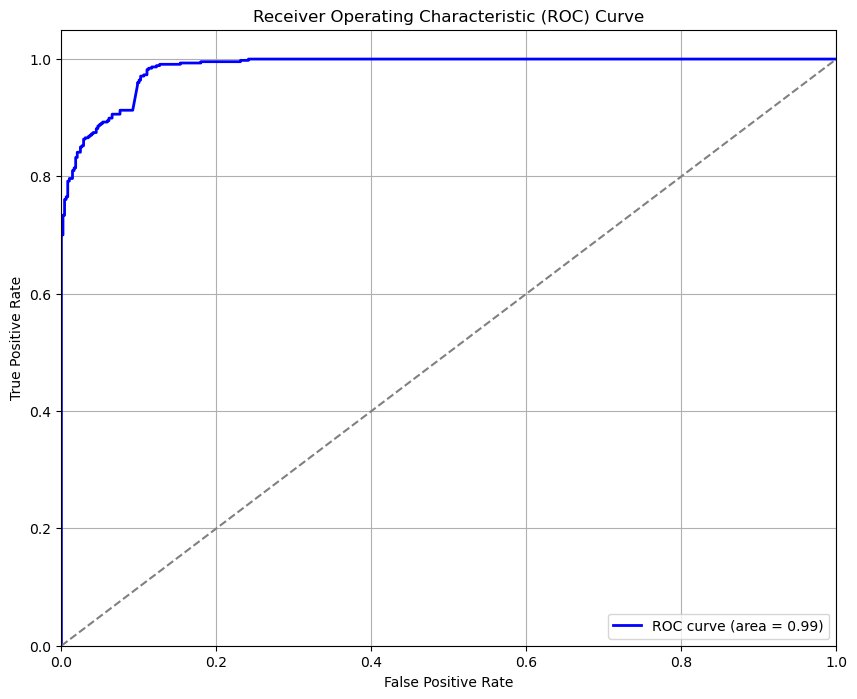

ROC AUC Score: 0.99


In [25]:
# Plotting the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f'ROC AUC Score: {roc_auc:.2f}')

In [49]:
import cv2
import numpy as np

def predict_image(image_path):
    image_size = (224, 224)
    img = cv2.imread(image_path)

    
    if img is None:
        raise FileNotFoundError(f"Failed to load image. Please check the file path: {image_path}")

    img = cv2.resize(img, image_size)
    img = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img)
    return prediction


image_path = r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\test\fractured\1-rotated1-rotated1_jpg.rf.662d450cdb55c615243f1e090fd71dbe.jpg'
try:
    result = predict_image(image_path)
    print(f'The image is: {result}')
except FileNotFoundError as e:
    print(e)

1/1 [==============================] - 0s 219ms/step
The image is: [[4.0777607e-07]]


In [50]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow import keras

In [51]:
# Load the trained model
model = keras.models.load_model("my_keras_model.h5")

In [52]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    image = load_img(image_path, target_size=target_size)
    
    image = img_to_array(image)
   
    image = image / 255.0
    
    image = np.expand_dims(image, axis=0)
    return image
def predict_image(image_path):
    
    if not os.path.isfile(image_path):
        print(f"Error: The file '{image_path}' does not exist. Please check the path.")
        return None
    
    
    processed_image = preprocess_image(image_path)
    
    prediction = model.predict(processed_image)
    
    score = prediction[0][0]
    
    threshold = 0.5
    
    class_names = ['Fractured', 'Not Fractured']
    
    predicted_label = class_names[1] if score >= threshold else class_names[0]
    
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} ({score:.2e})")  
    plt.axis('off')
    plt.show()
    
    return predicted_label

1/1 [==============================] - 0s 205ms/step


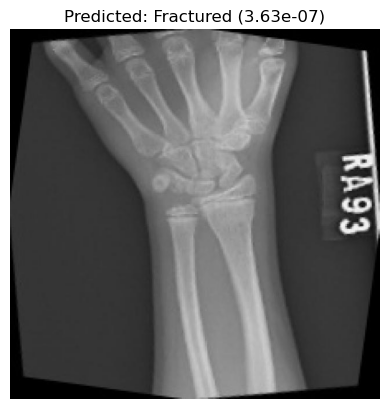

The predicted label for the image is: Fractured


In [53]:
sample_image_path = r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\test\fractured\1-rotated1-rotated1_jpg.rf.662d450cdb55c615243f1e090fd71dbe.jpg'
predicted_label = predict_image(sample_image_path)
if predicted_label:
    print(f"The predicted label for the image is: {predicted_label}")